# forecast_rental_price_of_residential

In [2]:
import os
import re
import sys
import calendar
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
import category_encoders as ce

from self_lib import tr_text as trtx
from self_lib import rpl_text
from self_lib import utils

# 可視化
from self_lib.graph import graph 

#tips
from self_lib import tips 
%matplotlib inline

# warningの無視
import warnings
warnings.filterwarnings('ignore')

# 表示列数を指定
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# font
plt.rcParams["font.family"] = "IPAexGothic"
## fontdict
# font = {'family'  : 'IPAexGothic',  #フォントファミリー
#         'color'   : 'navy',         #フォントカラー
#         'style'   : 'italic',       #イタリック
#         'weight'  : 'bold',         #フォントウェイト
#         'size'    : '14',           #フォントサイズ
#         'rotation': 90              # 90度回転
#         }

In [3]:
# 変換リスト
df_madori=pd.DataFrame({
    '間取り':['1R',
    '1K','1DK','1DKS','1KS','1LK','1LKS','1LDK','1LDKS',
    '2K','2DK','2DKS','2KS','2LK','2LKS','2LDK','2LDKS',
    '3K','3DK','3DKS','3KS','3LK','3LKS','3LDK','3LDKS',
    '4K','4DK','4DKS','4KS','4LK','4LKS','4LDK','4LDKS',
    '5K','5DK','5DKS','5KS','5LK','5LKS','5LDK','5LDKS',
    '6K','6DK','6DKS','6KS','6LK','6LKS','6LDK','6LDKS']
})

dic_stracture={'木造': 'W', 
              '鉄骨造':'S' , '軽量鉄骨':'S' , 
              '鉄骨鉄筋コンクリート':'SRC' ,'鉄筋コンクリート':'RC' ,
              '軽量気泡コンクリート':'ALC' , 
              'プレキャスト・コンクリート':'PC' ,'重量鉄骨':'HPC' ,
               'ブロック':'B' , 'その他':'other'}

## データ読込み

In [4]:
train_raw_data = pd.read_csv('../data/train.csv')
data = pd.DataFrame(train_raw_data)

EDA

In [5]:
data.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31470 entries, 0 to 31469
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31470 non-null  int64 
 1   賃料      31470 non-null  int64 
 2   所在地     31470 non-null  object
 3   アクセス    31470 non-null  object
 4   間取り     31470 non-null  object
 5   築年数     31470 non-null  object
 6   方角      28721 non-null  object
 7   面積      31470 non-null  object
 8   所在階     31470 non-null  object
 9   バス・トイレ  31141 non-null  object
 10  キッチン    30849 non-null  object
 11  放送・通信   28030 non-null  object
 12  室内設備    31388 non-null  object
 13  駐車場     26183 non-null  object
 14  周辺環境    22038 non-null  object
 15  建物構造    31470 non-null  object
 16  契約期間    24350 non-null  object
dtypes: int64(2), object(15)
memory usage: 4.1+ MB


## 前処理

In [7]:
# id を削除
data=data.drop(labels='id',axis=1)

EDA

In [8]:
len(data['所在地'])

31470

In [9]:
data['所在地'].isna().sum()

0

In [10]:
i=0
for strPrefecture in data['所在地']:
    if '東京都' in strPrefecture:
        i += 1
    else:
        pass
print(i)

31470


->　欠損値なく、すべて東京都内

## 正規化処理

In [11]:
# 住所の分割
data[["都道府県", "区"]] = data['所在地'].str.split("都", expand=True)
data['都道府県'] = data['都道府県'] + "都"
data[["区", "地区"]] = data['区'].str.split("区", expand=True)
data['区'] = data['区'] + "区"

data['地区']=data['地区'] .map(trtx.zen_han)
# train_data['地区']=train_data['地区'] .map(trtx.tr_areas)

# data['地区']=data['地区'].str.replace('丁目','AoB')
data['地区']=data['地区'].str.replace('丁目','o')

data['番地']=data['地区'].str.split("o",expand=True)[1]
data['地区']=data['地区'].str.split("o",expand=True)[0]

In [12]:
# 間取りの表現を正規化
l_m=data['間取り']
l_m=l_m.map(trtx.zen_han)
l_m=l_m.str.replace("納戸","").str.replace("K\+S","KS").str.replace("\(","").str.replace("\)","")
data['間取り']=l_m

In [13]:
# 建物構造を正規化
i=0
l_s=[]
for stracture in data['建物構造']:
    type_s=rpl_text.dic_val(stracture,dic_stracture)
    l_s.append(type_s)
    i += 1
data['type']=l_s

In [14]:
# 築年数を正規化

# 年月に分割
data[['p_year','p_month']]= data['築年数'].str.split("年", expand=True)
data['p_month']=data['p_month'].str.replace('ヶ月',"")

# 新築を０年０ヶ月に変換
data['p_year']=data['p_year'].str.replace('新築',"0")
data['p_month']=data['p_month'].str.replace('新築',"0")
data['p_month']=data['p_month'].fillna('0')

# 型変換（int64）
data['p_year']=data['p_year'].astype('int64')
data['p_month']=data['p_month'].astype('int64')

In [15]:
# 面積を正規化
# 単位を削除
data['面積']=data['面積'].str.replace('m2',"")
# 型変換（float）
data['面積']=data['面積'].astype('float')

In [16]:
# 所在階を正規化
data[['階','階建て']]=data['所在階'].str.split("／", expand=True)
data['階']=data['階'].str.replace('階',"")
data['階建て']=data['階建て'].str.replace('階建',"")

In [17]:
a_data=data.copy()

In [18]:
# バス・トイレ/キッチン/放送通信を正規化

facility=["バス・トイレ","キッチン","放送・通信"]

for f in facility: 
    # 改行を削除
    a_data[f]=a_data[f].str.replace("\t","")
    
    # 表現を統一
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ1口）","コンロ1口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ2口）","コンロ2口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ3口）","コンロ3口")
    a_data[f]=a_data[f].str.replace("コンロ設置可（コンロ4口以上）","コンロ4口以上")
    a_data[f]=a_data[f].str.replace("コンロ設置可（口数不明）","コンロ1口")
    
    # 分割してリストに格納
    l_facility=[]

    for word in pd.Series(a_data[f]):
        if type(word) is str:
            l_facility.append(word.split("／"))
        else: #欠損値行に欠損値を与える
            l_facility.append(np.nan)      

    # ダミー変数化
    facility = pd.Series(l_facility,name="facility")
    df=facility.str.join(sep=',').str.get_dummies(sep=',')
    a_data=pd.concat([df,a_data],axis=1)
    
    #EDA
#     print(df.sum())

In [19]:
b_data=a_data.copy()

契約期間  

|Y|定期借家|期間|
|---|---|---|
|2|Null|Null|
|2|1|2|

In [ ]:
tips.date


In [33]:
# 契約期間を正規化

# 不要文言削除
term = b_data["契約期間"].copy()
term = term.str.replace("※この物件は","")
term = term.str.replace("です。","")
term = term.str.replace("\t",";")

for word in term:
    teiki=""
    if type(word) is str:
        l_term = word.split(";")
        while '' in l_term: 
            l_term:l_term.remove('')
        
        if "定期借家" in word:
            teiki=1
            print(l_term[1])
        else:
            pass
        
        if "まで" in word:
            target_term=l_term[0]
            target_term=target_term.replace("まで","")
            target_term=target_term.replace("年","/")
            target_term=target_term.replace("月","")
            y=pd.datetime.strptime(target_term, '%Y')
            print(y)
            m=pd.datetime.strptime(target_term, '%m')
            print(m)
            datetime.date(y, m, calendar.monthrange(y, m)[1])
            print(l_term[0])
            print(target_term)
        else:
            print(l_term[0])
            
#         print(l_term)
    else: #欠損値行に欠損値を与える
#         l_facility.append(np.nan)
        pass
    

2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
1年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
5年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
定期借家
5年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
1年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
3年間
2年間
2年間
2年間
2年間
2ヶ月間
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
5年間
2年間
定期借家
3年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
1年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
5年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
4年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
1年間
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
2年間
定期借家
2年間
2年間
定期借家
4年間
定期借家


ValueError: unconverted data remains: /4

In [115]:
b_data["契約期間"].unique()

array(['2年間', '2年間\t※この物件は\t定期借家\tです。', nan, '1年間',
       '5年間\t※この物件は\t定期借家\tです。', '1年間\t※この物件は\t定期借家\tです。',
       '3年間\t※この物件は\t定期借家\tです。', '2ヶ月間', '4年間\t※この物件は\t定期借家\tです。',
       '2021年4月まで\t※この物件は\t定期借家\tです。', '2023年3月まで\t※この物件は\t定期借家\tです。',
       '2022年3月まで\t※この物件は\t定期借家\tです。', '2021年8月まで\t※この物件は\t定期借家\tです。',
       '1ヶ月間', '3年間', '2020年3月まで\t※この物件は\t定期借家\tです。', '5年間',
       '2021年2月まで\t※この物件は\t定期借家\tです。', '22年間', '12年間',
       '2020年6月まで\t※この物件は\t定期借家\tです。', '4年間', '4年8ヶ月間\t※この物件は\t定期借家\tです。',
       '2021年7月まで\t※この物件は\t定期借家\tです。', '2022年6月まで\t※この物件は\t定期借家\tです。',
       '2021年3月まで\t※この物件は\t定期借家\tです。', '2021年12月まで\t※この物件は\t定期借家\tです。',
       '3年3ヶ月間\t※この物件は\t定期借家\tです。', '2022年7月まで\t※この物件は\t定期借家\tです。',
       '2年6ヶ月間\t※この物件は\t定期借家\tです。', '2022年2月まで\t※この物件は\t定期借家\tです。',
       '1年10ヶ月間\t※この物件は\t定期借家\tです。', '2023年8月まで\t※この物件は\t定期借家\tです。',
       '2020年5月まで\t※この物件は\t定期借家\tです。', '7年間\t※この物件は\t定期借家\tです。',
       '10年間\t※この物件は\t定期借家\tです。', '2021年1月まで\t※この物件は\t定期借家\tです。',
       '20

In [110]:
# 室内設備を正規化

facility=["室内設備"]

for f in facility: 
    # 改行を削除
    b_data[f]=b_data[f].str.replace("\t"," ")
    b_data[f]=b_data[f].str.replace("／"," ")
    b_data[f]=b_data[f].str.replace("\\"," ")
    
    # 分割してリストに格納
    l_facility_room=[]

    for word in pd.Series(b_data[f]):
        if type(word) is str:
            l_facility_room.append(word.split(" "))
        else: #欠損値行に欠損値を与える
            l_facility_room.append(np.nan)      

    # ダミー変数化
    facility_r = pd.Series(l_facility_room,name="facility")
    df=facility_r.str.join(sep=',').str.get_dummies(sep=',')
    b_data=pd.concat([df,b_data],axis=1)
    
    #EDA
#     print(df.sum())

In [111]:
#EDA
b_data["アクセス"].unique()

array(['都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\t西ケ原四丁目駅\t徒歩7分',
       '都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\t築地駅\t徒歩20分',
       '京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅\t徒歩17分', ...,
       '東西線\t南砂町駅\t徒歩5分\t\t都営新宿線\t大島(東京都)駅\t徒歩26分\t\t東西線\t東陽町駅\t徒歩18分',
       '中央線（快速）\t中野(東京都)駅\t徒歩4分\t\t丸ノ内線(池袋－荻窪)\t新中野駅\t徒歩10分\t\t丸ノ内線(池袋－荻窪)\t東高円寺駅\t徒歩15分',
       '有楽町線\t千川駅\t徒歩5分\t\t有楽町線\t要町駅\t徒歩13分\t\t西武池袋線\t東長崎駅\t徒歩17分'],
      dtype=object)

In [112]:
c_data=b_data.copy()

In [114]:
# アクセスを正規化

# 表現を変更
c_data["アクセス"]=c_data["アクセス"].str.replace("\t\t",";")
c_data["アクセス"]=c_data["アクセス"].str.replace("\t",",")

# 分割してリストに格納
l_access=[]
for word in pd.Series(c_data["アクセス"]):
    if type(word) is str: 
        l_access.append(word.split(";"))
    else: #欠損値行に欠損値を与える
        l_facility_room.append(np.nan)
        
    # ダミー変数化
    access = pd.Series(l_access,name="access")
    df=access.str.join(sep=';').str.get_dummies(sep=';')
    c_data=pd.concat([df,c_data],axis=1)
    
    #EDA
    print(df.sum())

埼京線,板橋駅,徒歩14分         1
都営三田線,西巣鴨駅,徒歩4分       1
都電荒川線,西ケ原四丁目駅,徒歩7分    1
dtype: int64
埼京線,板橋駅,徒歩14分         1
日比谷線,築地駅,徒歩20分        1
有楽町線,月島駅,徒歩9分         1
都営三田線,西巣鴨駅,徒歩4分       1
都営大江戸線,勝どき駅,徒歩5分      1
都電荒川線,西ケ原四丁目駅,徒歩7分    1
dtype: int64
京王線,代田橋駅,徒歩7分         1
京王線,明大前駅,徒歩17分        1
京王線,笹塚駅,徒歩6分          1
埼京線,板橋駅,徒歩14分         1
日比谷線,築地駅,徒歩20分        1
有楽町線,月島駅,徒歩9分         1
都営三田線,西巣鴨駅,徒歩4分       1
都営大江戸線,勝どき駅,徒歩5分      1
都電荒川線,西ケ原四丁目駅,徒歩7分    1
dtype: int64
丸ノ内線(池袋－荻窪),新高円寺駅,徒歩3分     1
丸ノ内線(池袋－荻窪),東高円寺駅,徒歩14分    1
京王線,代田橋駅,徒歩7分              1
京王線,明大前駅,徒歩17分             1
京王線,笹塚駅,徒歩6分               1
埼京線,板橋駅,徒歩14分              1
日比谷線,築地駅,徒歩20分             1
有楽町線,月島駅,徒歩9分              1
総武線・中央線（各停）,高円寺駅,徒歩9分      1
都営三田線,西巣鴨駅,徒歩4分            1
都営大江戸線,勝どき駅,徒歩5分           1
都電荒川線,西ケ原四丁目駅,徒歩7分         1
dtype: int64
丸ノ内線(池袋－荻窪),新高円寺駅,徒歩3分     1
丸ノ内線(池袋－荻窪),東高円寺駅,徒歩14分    1
京成金町線,京成金町駅,徒歩5分           1
京成金町線,柴又駅,徒歩17分            1
京王線,代田橋駅,徒歩7分              1
京王線,明大前駅,徒歩17分         

KeyboardInterrupt: 

<AxesSubplot:>

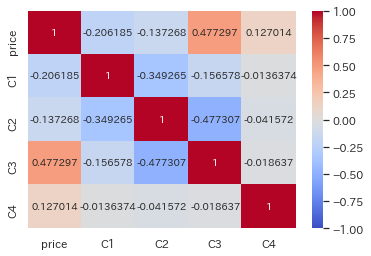

In [20]:
#EDA
cor_data=a_data[["賃料","コンロ1口","コンロ2口","コンロ3口","コンロ4口以上"]].copy()
cor_data=cor_data.rename(columns={"賃料":"price","コンロ1口":"C1","コンロ2口":"C2","コンロ3口":"C3","コンロ4口以上":"C4"})
sns.heatmap(cor_data.corr(),annot=True, fmt='g', cmap='coolwarm',vmin=-1,vmax=1)

-> C2,C3は賃料への影響が比較的高い  
それ以外は相関は低そう

In [34]:
#EDA
cor_data2=a_data[["賃料","コンロ1口","コンロ2口","コンロ3口","コンロ4口以上","コンロ設置可（口数不明）"]].copy()
cor_data2=cor_data2.rename(columns={"賃料":"price","コンロ1口":"C1","コンロ2口":"C2","コンロ3口":"C3","コンロ4口以上":"C4","コンロ設置可（口数不明）":"Cn"})

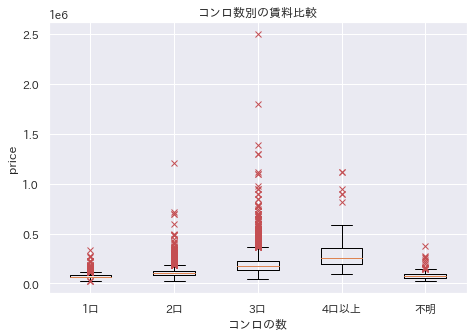

In [35]:
g=graph()
g.cmp_box(ol_vis=0,
    title="コンロ数別の賃料比較",
    x_title="コンロの数",
    y_title= "price",
    labels=["1口","2口","3口","4口以上","不明"],
    dataset=[cor_data2['price'][cor_data2['C1']==1],
    cor_data2['price'][cor_data2['C2']==1],
    cor_data2['price'][cor_data2['C3']==1],
    cor_data2['price'][cor_data2['C4']==1],
    cor_data2['price'][cor_data2['Cn']==1]])

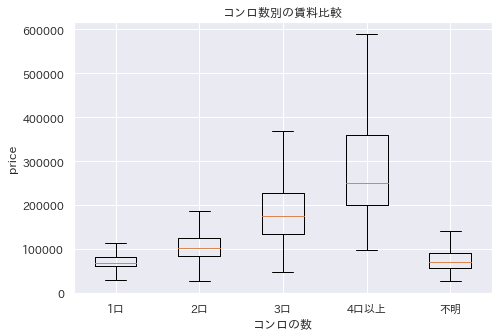

In [36]:
g=graph()
g.cmp_box(ol_vis=1,
    title="コンロ数別の賃料比較",
    x_title="コンロの数",
    y_title= "price",
    labels=["1口","2口","3口","4口以上","不明"],
    dataset=[cor_data2['price'][cor_data2['C1']==1],
    cor_data2['price'][cor_data2['C2']==1],
    cor_data2['price'][cor_data2['C3']==1],
    cor_data2['price'][cor_data2['C4']==1],
    cor_data2['price'][cor_data2['Cn']==1]])

->　不明分は１口に寄せてもよさそう

## 方針

 >  Sのあるなしで賃料がゆれているため、Sありのフラグをたてるべき
 > >OneHotEncodingで対応  
   
 > 線路/交通手段/時間で一つのカテゴリを作成する  
  
 > 階数は高いほどよいが、3F以上はエレベーターがついているかが肝

## 分析

In [26]:
c_data=data.copy()

In [27]:
def m_plot_2(x_label,label_A,label_B,Series_A,Series_B):
    """折れ線グラフ
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(Series_A)
    ax.plot(Series_B)
    ax.set_xlabel(x_label)
    plt.show()

In [28]:
#賃料とtype/madoriの関係を確認する
r_data=c_data[['賃料','type','間取り']]
rg=r_data.groupby('間取り')
rg_mean=rg.mean()
rg_median=rg.median()

<AxesSubplot:>

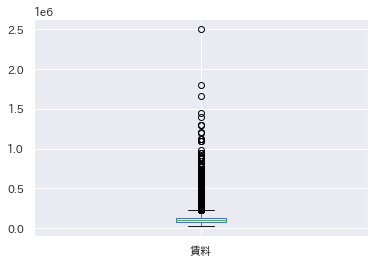

In [29]:
r_data.plot.box()

間取りでグループした場合の賃料に外れ値あり

In [ ]:
# 間取りの順序を取得する
l2=df_madori.reset_index()
l2=l2.rename(columns={'index':'order'})

In [ ]:
# mean に間取りの順序を適用する
rgl_mean=pd.merge(rg_mean,l2,on='間取り')
rgl_mean=rgl_mean.rename(columns={'賃料':'mean'})
rgl_mean=rgl_mean.sort_values('order')
rgl_mean=rgl_mean.reset_index(drop=True)
# rgl_mean

In [ ]:
# mean に間取りの順序を適用する
rgl_median=pd.merge(rg_median,l2,on='間取り')
rgl_median=rgl_median.rename(columns={'賃料':'median'})
rgl_median=rgl_median.sort_values('order')
rgl_median=rgl_median.reset_index(drop=True)
rgl_median

In [ ]:
# 表をマージする
rgl=pd.merge(rgl_mean,rgl_median,on='間取り')
rgl=rgl.sort_values('order_x')
rgl=rgl.drop(columns=['order_x','order_y'])
rgl.plot.line()
plt.show()
m_plot_2('test','mean','median',rgl_mean['mean'],rgl_median['median'])
# print(rgl)
print(rgl_median['間取り'])

In [ ]:
data.head()

In [ ]:
# 不要な列の削除
# c_data.drop(columns=['建物構造','所在地'])

In [ ]:
corr_data['madori'].unique()

In [ ]:
corr_data['madori'].value_counts()

In [ ]:
x = corr_data['madori'].value_counts().index
y = corr_data['madori'].value_counts()

graph.m_scatter_s("madori","count",x,y)

In [ ]:
# # OneHotEncoding

# #インスタンス化
# encoder = ce.OneHotEncoder(use_cat_names=True)

# # 学習
# encoder.fit(c_data.drop('madori',axis=1))

# # 変換
# d_data = encoder.transform(c_data.drop('madori',axis=1))


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # OneHotEncoderでのencoding
# ohe =OneHotEncoder(sparse=False,categories='auto')
# ohe.fit(c_data['間取り'])

# # ダミー変数の列名作成
# columns=[]
# for i,c in enumerate('間取り'):
#     columns += [f'7{c}_{v}' for v in ohe.categories_[i]]

# # 生成されたダミー変数をデータフレームに変換
# c_data=pd.DataFrame(ohe.transform(c_data['間取り']),columns=columns)
    